In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
sns.set_theme(style='darkgrid')

In [2]:
from data import get_price_data
from backtest import backtest_strat
from helpers import resume_backtest, performance_plot, annual_alpha_plot, price_to_perf, correlation, pred_to_perf, prob_to_pred

In [3]:
price, bench_price, df_X = get_price_data()
daily_returns = price.pct_change().shift(1)

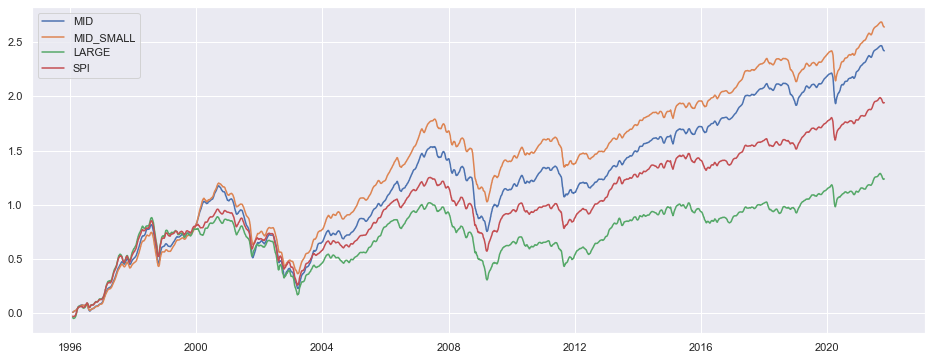

In [4]:
fig, ax = plt.subplots(figsize=(16,6))
data_plot = (pd.concat([price, bench_price.rename('SPI')], axis=1).pct_change() + 1).cumprod().rolling(20).mean()
sns.lineplot(data=np.log(data_plot), dashes=False)
plt.show()

In [10]:
models_list = ['MLP', 'ConvNet', 'LSTM']
# models_list = ['MLP', 'ConvNet']
# models_list = ['MLP']
df_pred_dict = {}
df_prob_dict = {}

threshold = 0.8
batch_size = 10
verbose = 0
training_window = 5
nb_epochs = 2
rebalance_freq = 'W-FRI'
input_period_days = 42
input_period_weeks = 8
eta = 5e-4
weight_decay = 1e-4

if rebalance_freq == 'M':
    input_period = input_period_weeks
else:
    input_period = input_period_days

for i, model_name in enumerate(models_list):
    df_prob_dict[model_name] = backtest_strat(df_input_all=df_X, price=price, rebalance_freq=rebalance_freq, 
                                              model_name=model_name, nb_epochs=nb_epochs, 
                                              input_period=input_period, 
                                              batch_size=batch_size, verbose=verbose, 
                                              training_window=training_window, threshold=threshold, 
                                              eta=eta, weight_decay=weight_decay)
    df_pred_dict[model_name] = prob_to_pred(df_prob_dict[model_name], threshold)

    if i == 0:
        df_prob_dict['Ensemble'] = df_prob_dict[model_name].copy()
    else:
        df_prob_dict['Ensemble'] += df_prob_dict[model_name]

df_prob_dict['Ensemble'] /= len(models_list)
df_pred_dict['Ensemble'] = prob_to_pred(df_prob_dict[model_name], threshold)

Backtesting model MLP


100%|██████████| 40/40 [00:05<00:00,  7.86it/s]


Backtesting model ConvNet


100%|██████████| 40/40 [00:06<00:00,  5.91it/s]


Backtesting model LSTM


100%|██████████| 40/40 [00:23<00:00,  1.67it/s]


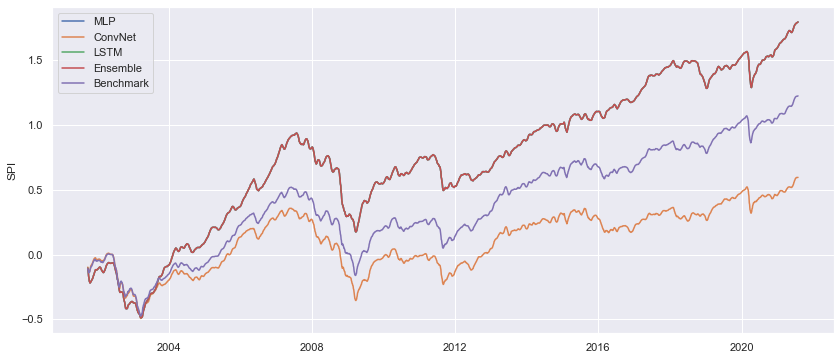

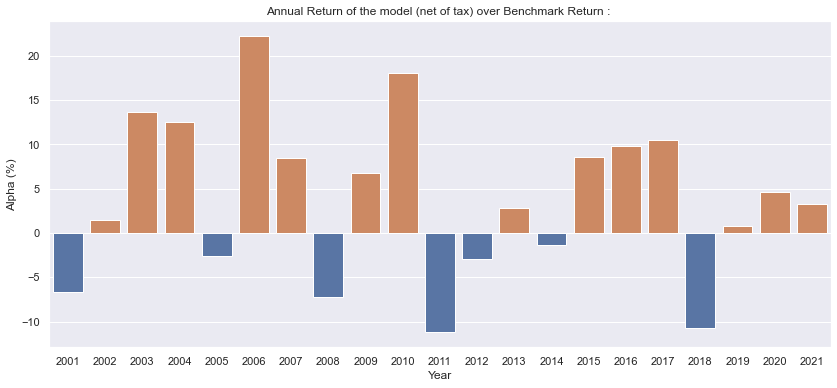

,Gross avg. annual return (%),Net avg. annual return (%),Avg. annual vol. (%),Avg Sharpe ratio,Max. Drawdown (%),Turnover
Benchmark SPI,7.47,7.47,17.40,0.43,44.52,0
MLP,11.32,11.32,14.43,0.78,47.72,0
ConvNet,4.39,4.39,18.23,0.24,45.09,0
LSTM,11.32,11.32,14.43,0.78,47.72,0
Ensemble,11.32,11.32,14.43,0.78,47.72,0


In [11]:
df_resume = resume_backtest(df_pred_dict, bench_price, price)
daily_returns = price.pct_change().shift(1)
perf_bench = price_to_perf(bench_price.loc[df_pred_dict['Ensemble'].index[0]:df_pred_dict['Ensemble'].index[-1]], log=False)
performance_plot(df_pred_dict, daily_returns, bench_price, log=True)
annual_alpha_plot(perf_bench, df_pred_dict['Ensemble'], daily_returns)
display(df_resume)

In [12]:
df = pd.DataFrame(index=models_list, columns=models_list)
for comb in itertools.product(models_list, repeat=2):
    model1 = comb[0]
    model2 = comb[1]
    df.loc[model1][model2] = correlation(df_pred_dict[model1], df_pred_dict[model2])
df = df.astype(float)
df.round(2)

,MLP,ConvNet,LSTM
MLP,1.0,0.0,1.0
ConvNet,0.0,1.0,0.0
LSTM,1.0,0.0,1.0


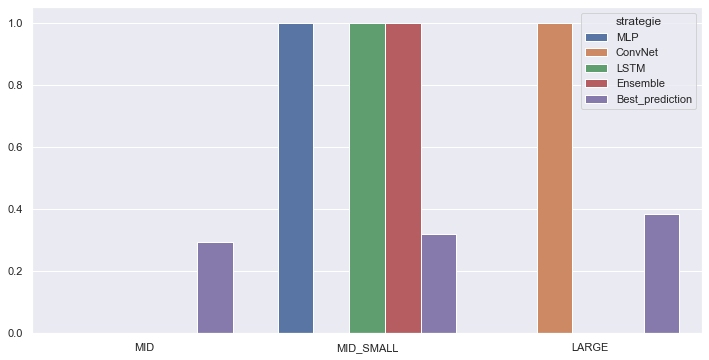

In [13]:
df_results = pd.DataFrame()

for model_name in df_pred_dict:
    L = len(df_pred_dict[model_name])
    df_results = pd.concat([df_results, (df_pred_dict[model_name].sum(axis=0) / L).rename(model_name)], axis=1)

returns = price.pct_change().shift(1).resample(rebalance_freq).agg(lambda x: (x + 1).prod() - 1)
best_pred = returns.rank(axis=1).replace({1: 0., 2: 0., 3: 1.}).shift(-1).loc[df_pred_dict[model_name].index[0]:df_pred_dict[model_name].index[-1]]

df_results = pd.concat([df_results, (best_pred.sum(axis=0) / L).rename('Best_prediction')], axis=1)
df_results = df_results.reset_index()
df_results = df_results.melt(id_vars='index', var_name='strategie', value_name='frequence')

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(data=df_results, x='index', y='frequence', hue='strategie')
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.show()